# Tariff-Impact-Analysis

### Load Library


In [37]:
# Load necessary libraries
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from sqlalchemy import create_engine
import urllib
import numpy as np


In [38]:
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["axes.facecolor"] = "#f7f7fa"
plt.rcParams["figure.facecolor"] = "#f7f7fa"
plt.rcParams["axes.edgecolor"] = "#e0e0e0"
plt.rcParams["axes.labelcolor"] = "#333333"
plt.rcParams["xtick.color"] = "#333333"
plt.rcParams["ytick.color"] = "#333333"

### Connect to SQL Server

In [39]:
params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=STATION-DEV\\SQLEXPRESS08;"
    "DATABASE=tariff;"
    "Trusted_Connection=yes;"
)

engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")


### Load the dataset into a DataFrame

In [40]:
# Load the data into a DataFrame
tia = pd.read_csv (r"D:\Project\Tariff Impact Analysis\Tariff-Impact-Analysis\Tariff Impact Analysis.csv")
  

# Testing Hypotesys 

In [41]:
price_comparison = (
    tia.groupby("product_name")[["price_before_USD", "price_after_USD"]]
    .mean()
    .round(2)
    .reset_index()
)

# Display the DataFrame in a table format
print(tabulate(price_comparison, headers="keys", tablefmt="psql", showindex=False))

+-----------------------+--------------------+-------------------+
| product_name          |   price_before_USD |   price_after_USD |
|-----------------------+--------------------+-------------------|
| Car                   |           20619.9  |          26990.4  |
| Car Parts             |           24136.8  |          30208.6  |
| Coffee                |              30.81 |             38.78 |
| Electronic Components |             797.21 |            982.11 |
| Footwear              |             103.52 |            131.78 |
| Furniture             |             802.81 |           1021.94 |
| Jeans                 |             111.02 |            147.04 |
| Laptop                |             699.62 |            876.41 |
| Olive Oil             |              29.71 |             36.29 |
| Refrigerator          |            1124.91 |           1424.29 |
| Smartphone            |             798.81 |           1017.71 |
| TV                    |             727.14 |            917.

# Visualization

### Product Price Comparation

Text(0.5, 33.109374999999986, 'Metric')

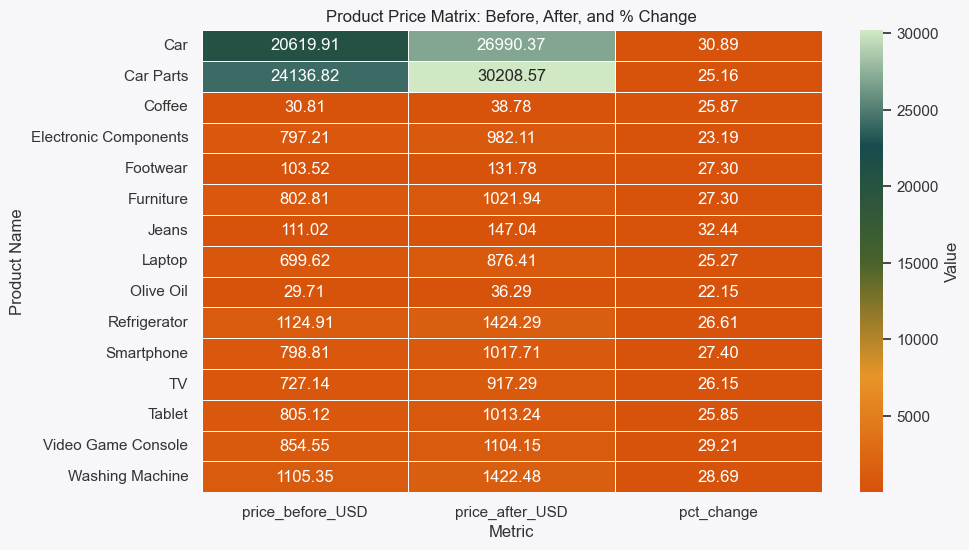

In [73]:
# Prepare data for matrix/heatmap
price_comparison = (
    tia.groupby("product_name")[["price_before_USD", "price_after_USD"]]
    .mean()
    .round(2)
    .reset_index()
)
price_comparison["pct_change"] = (
    (price_comparison["price_after_USD"] - price_comparison["price_before_USD"])
    / price_comparison["price_before_USD"] * 100
).round(2)

# Set product_name as index for heatmap
matrix_data = price_comparison.set_index("product_name")[["price_before_USD", "price_after_USD", "pct_change"]]

# Custom colormap using your colors
from matplotlib.colors import LinearSegmentedColormap
custom_colors = ["#D7520A", "#E89528", "#47622B", "#174B4C", "#D0E8C4"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=256)

plt.figure(figsize=(10, max(6, len(matrix_data) * 0.4)))
sns.heatmap(
    matrix_data,
    annot=True,
    fmt=".2f",
    cmap=custom_cmap,
    linewidths=0.5,
    cbar_kws={'label': 'Value'}
)
plt.title("Product Price Matrix: Before, After, and % Change")
plt.ylabel("Product Name")
plt.xlabel("Metric")

### Averange Price Before and After Tariff 

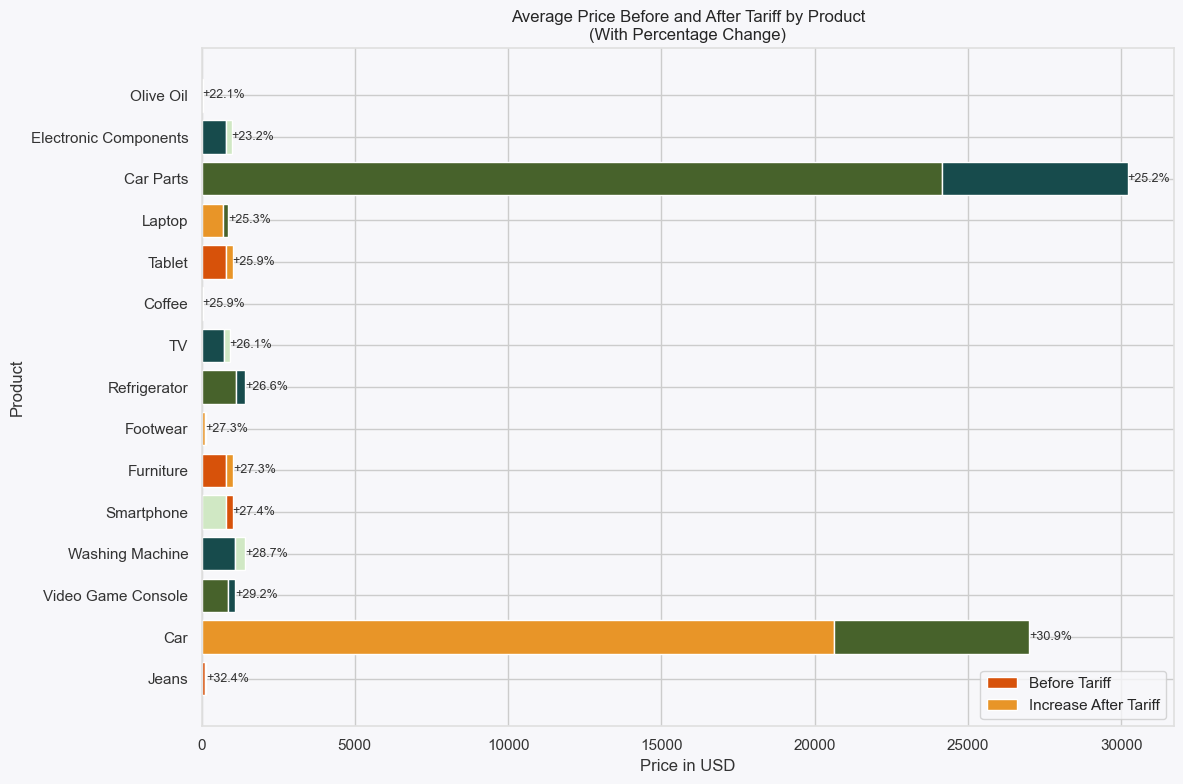

In [74]:
# Prepare data with percentage change column
price_comparison = (
    tia.groupby("product_name")[["price_before_USD", "price_after_USD"]]
    .mean()
    .round(2)
    .reset_index()
)
price_comparison["pct_change"] = (
    (price_comparison["price_after_USD"] - price_comparison["price_before_USD"])
    / price_comparison["price_before_USD"] * 100
).round(2)

# Sort by percentage change for better visualization
price_comparison = price_comparison.sort_values("pct_change", ascending=False)

# Custom color palette
custom_colors = ["#D7520A", "#E89528", "#47622B", "#174B4C", "#D0E8C4"]

# Assign colors for bars (cycle through custom palette)
before_colors = [custom_colors[i % len(custom_colors)] for i in range(len(price_comparison))]
after_colors = [custom_colors[(i+1) % len(custom_colors)] for i in range(len(price_comparison))]

plt.figure(figsize=(12, 8))
bar1 = plt.barh(
    price_comparison["product_name"],
    price_comparison["price_before_USD"],
    color=before_colors,
    label="Before Tariff"
)
bar2 = plt.barh(
    price_comparison["product_name"],
    price_comparison["price_after_USD"] - price_comparison["price_before_USD"],
    left=price_comparison["price_before_USD"],
    color=after_colors,
    label="Increase After Tariff"
)

# Annotate percentage change
for i, (after, pct) in enumerate(zip(price_comparison["price_after_USD"], price_comparison["pct_change"])):
    plt.text(
        after + 0.5, i,
        f"{pct:+.1f}%",
        va="center",
        fontsize=9,
        color="#333333"
    )

plt.xlabel("Price in USD")
plt.ylabel("Product")
plt.title("Average Price Before and After Tariff by Product\n(With Percentage Change)")
plt.legend(loc="lower right")
plt.tight_layout()

### Price Before and After Tariff 

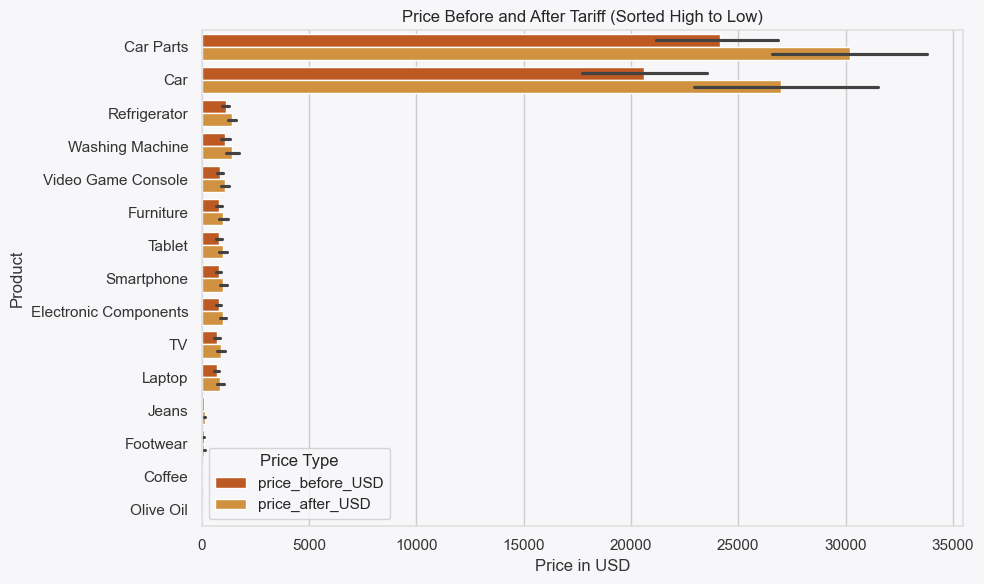

In [75]:
# 1. Price Before vs After (Bar Plot)

plt.figure(figsize=(10, 6))

# Melt for plotting
price_melted = tia.melt(
    id_vars="product_name", 
    value_vars=["price_before_USD", "price_after_USD"],
    var_name="Price Type", value_name="Price"
)

# Sort by average price (for meaningful ordering)
avg_prices = price_melted.groupby("product_name")["Price"].mean().sort_values(ascending=False).index
price_melted["product_name"] = pd.Categorical(price_melted["product_name"], categories=avg_prices, ordered=True)

# Custom palette for "Price Type"
custom_palette = ["#D7520A", "#E89528"]

# Plot
sns.barplot(
    data=price_melted, 
    y="product_name", x="Price", 
    hue="Price Type", palette=custom_palette
)

plt.title("Price Before and After Tariff (Sorted High to Low)")
plt.ylabel("Product")
plt.xlabel("Price in USD")
plt.tight_layout()
plt.show()



In [64]:
# 3. Units Sold Before vs After Tariff (Bar Plot)
tia["unit_diff"] = tia["units_sold_after"] - tia["units_sold_before"]


### Units Sold: Before vs After Tariff

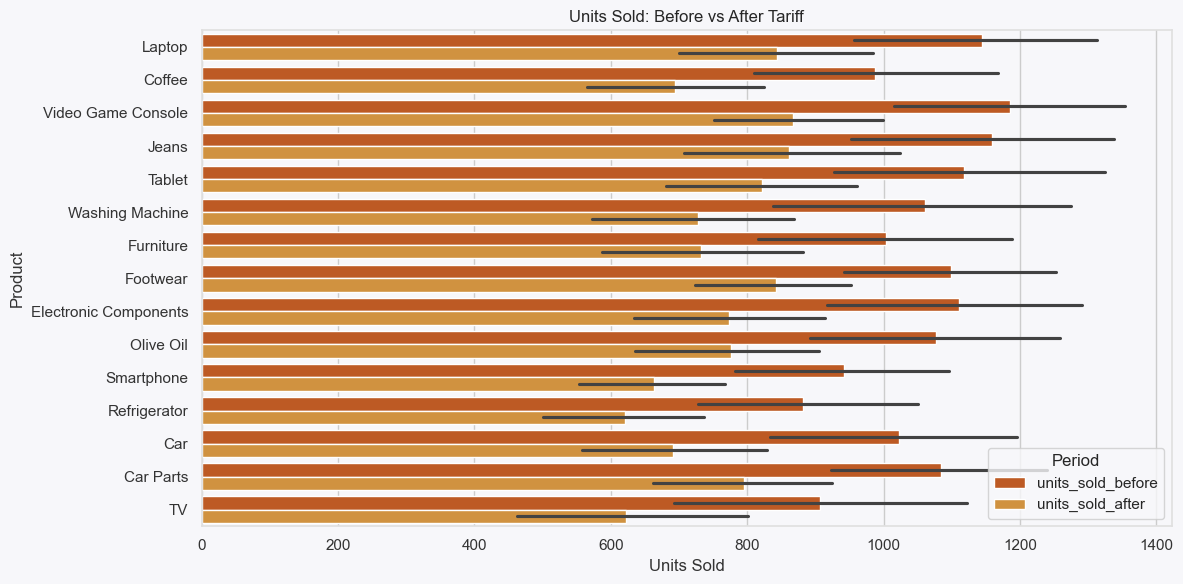

In [76]:
# Melt for plotting
melted_units = tia.melt(
    id_vars="product_name",
    value_vars=["units_sold_before", "units_sold_after"],
    var_name="Period",
    value_name="Units Sold"
)

# Custom palette for "Period"
custom_palette = ["#D7520A", "#E89528"]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=melted_units,
    x="Units Sold",
    y="product_name",
    hue="Period",
    palette=custom_palette
)

plt.title("Units Sold: Before vs After Tariff")
plt.xlabel("Units Sold")
plt.ylabel("Product")
plt.tight_layout()


### Average Price Change After Tariff by Product Type

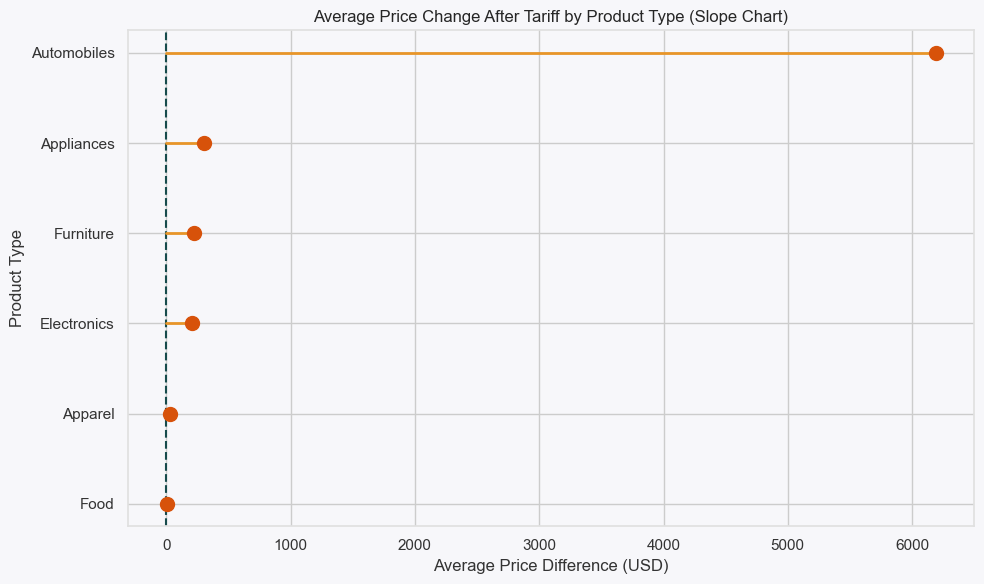

In [77]:
# 1. Create a new column for price difference
tia["price_diff"] = tia["price_after_USD"] - tia["price_before_USD"]

# 2. Calculate the average price difference by product type
grouped_price_diff = (
    tia.groupby("product_type")["price_diff"]
    .mean()
    .sort_values(ascending=True)
    .reset_index()
)

# Custom color palette for lines and points
custom_colors = ["#D7520A", "#E89528", "#47622B", "#174B4C", "#D0E8C4"]

plt.figure(figsize=(10, 6))
# Use two colors from your palette for points and lines
plt.scatter(
    grouped_price_diff["price_diff"],
    grouped_price_diff["product_type"],
    color=custom_colors[0],
    s=100,
    zorder=3
)
for i, row in grouped_price_diff.iterrows():
    plt.plot(
        [0, row["price_diff"]],
        [row["product_type"], row["product_type"]],
        color=custom_colors[1],
        linewidth=2,
        zorder=2
    )

plt.axvline(0, color=custom_colors[3], linestyle="--", zorder=1)
plt.title("Average Price Change After Tariff by Product Type (Slope Chart)")
plt.xlabel("Average Price Difference (USD)")
plt.ylabel("Product Type")
plt.tight_layout()

### Percentage Change in Average Product Price by Country

C:\Users\cleid\AppData\Local\Temp\ipykernel_29932\218233777.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




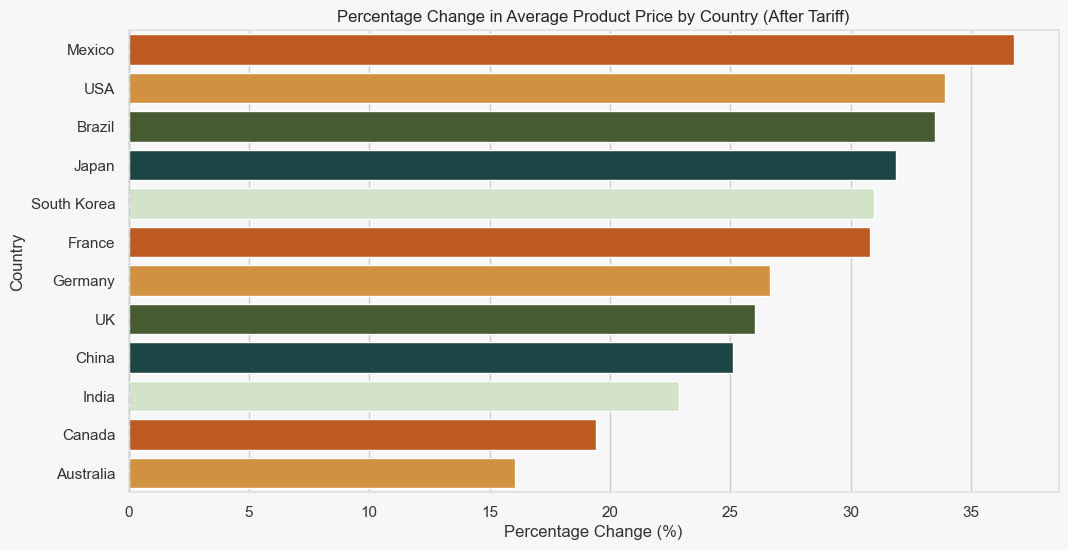

In [78]:
# 1. Calculate average prices
avg_price_change = tia.groupby("country")[["price_before_USD", "price_after_USD"]].mean().reset_index()

# 2. Calculate percentage change
avg_price_change["pct_change"] = ((avg_price_change["price_after_USD"] - avg_price_change["price_before_USD"]) /
                                  avg_price_change["price_before_USD"]) * 100

# 3. Sort
avg_price_change = avg_price_change.sort_values("pct_change", ascending=False)

# Custom color palette for countries (cycle through your palette)
custom_colors = ["#D7520A", "#E89528", "#47622B", "#174B4C", "#D0E8C4"]
palette = [custom_colors[i % len(custom_colors)] for i in range(len(avg_price_change))]

# 4. Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=avg_price_change,
    y="country",
    x="pct_change",
    palette=palette
)

# 5. Customize
plt.title("Percentage Change in Average Product Price by Country (After Tariff)")
plt.xlabel("Percentage Change (%)")
plt.ylabel("Country")
plt.axvline(0, color=custom_colors[3], linestyle="--")


### Distribution of Product Prices: Before vs After Tariff

C:\Users\cleid\AppData\Local\Temp\ipykernel_29932\4158831309.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




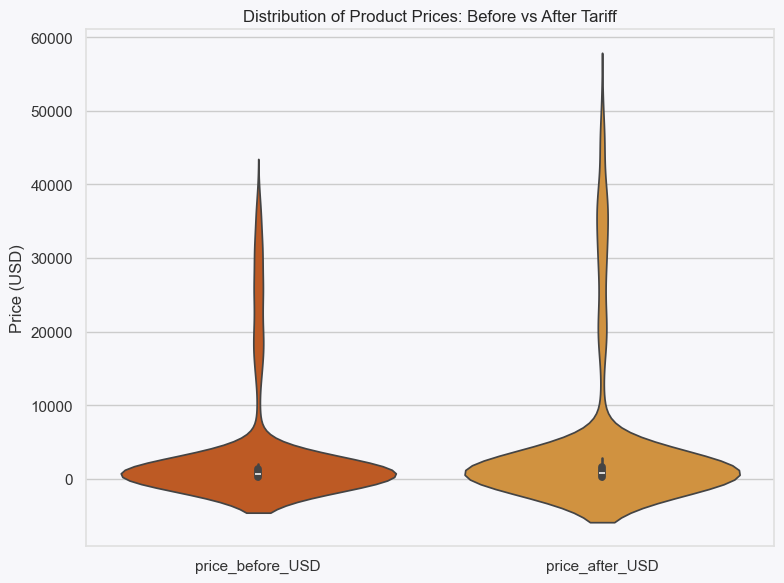

In [79]:
# Prepare data
violin_data = tia.melt(
    value_vars=["price_before_USD", "price_after_USD"],
    var_name="Period",
    value_name="Price"
)

# Custom palette for violin plot
custom_palette = ["#D7520A", "#E89528"]

plt.figure(figsize=(8, 6))
sns.violinplot(data=violin_data, x="Period", y="Price", palette=custom_palette)
plt.title("Distribution of Product Prices: Before vs After Tariff")
plt.ylabel("Price (USD)")
plt.xlabel("")
plt.tight_layout()
plt.show()

### Units Sold by Product Type Before & After Tariff

C:\Users\cleid\AppData\Local\Temp\ipykernel_29932\979272431.py:14: UserWarning:

The palette list has more values (12) than needed (2), which may not be intended.



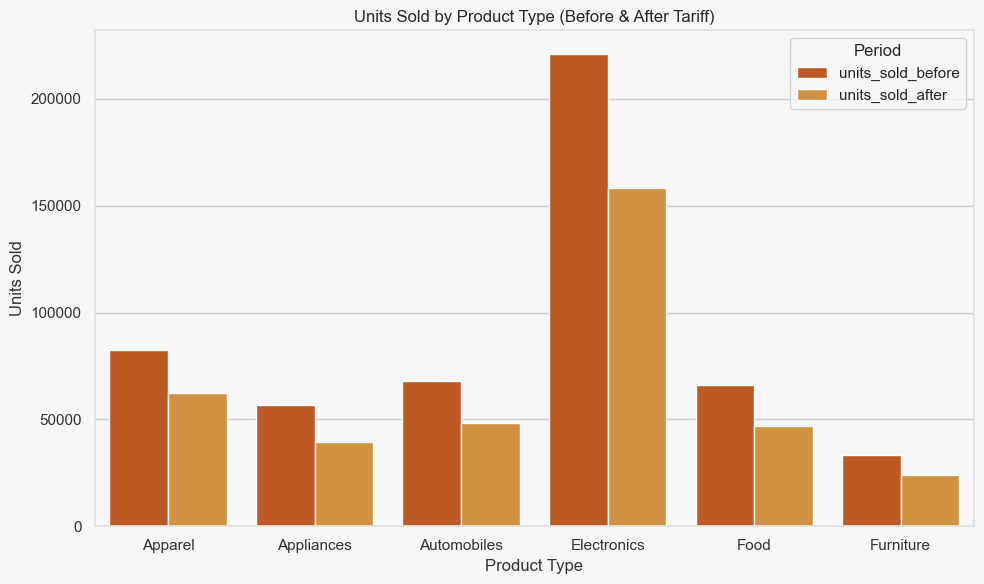

In [80]:
# Prepare data
custom_palette = ["#D7520A", "#E89528"]  # Use your specified colors

# Melt grouped_units for seaborn barplot
melted_grouped_units = pd.melt(
	grouped_units,
	id_vars="product_type",
	value_vars=["units_sold_before", "units_sold_after"],
	var_name="Period",
	value_name="Units Sold"
)

plt.figure(figsize=(10, 6))
sns.barplot(
	data=melted_grouped_units,
	x="product_type",
	y="Units Sold",
	hue="Period",
	palette=palette
)
plt.title("Units Sold by Product Type (Before & After Tariff)")
plt.ylabel("Units Sold")
plt.xlabel("Product Type")
plt.tight_layout()
plt.show()



### Heatmap of Units Sold by Product Type and Period

Text(0.5, 33.249999999999986, 'Period')

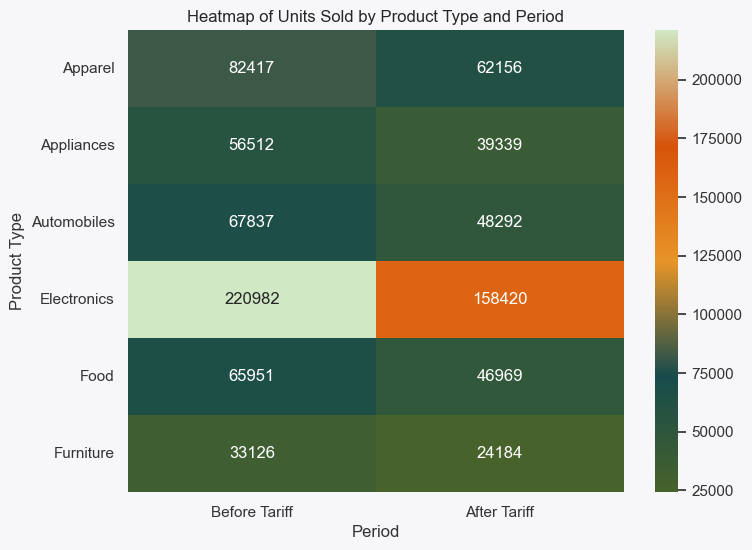

In [83]:
# Prepare data

heatmap_data = tia.groupby("product_type")[["units_sold_before", "units_sold_after"]].sum()
heatmap_data = heatmap_data.rename(columns={"units_sold_before": "Before Tariff", "units_sold_after": "After Tariff"})

# Custom colormap using a more balanced mix of your palette
from matplotlib.colors import LinearSegmentedColormap
# Use all 5 colors, but start with green, blue, orange, yellow, light green for more variety
custom_colors = ["#47622B", "#174B4C", "#E89528", "#D7520A", "#D0E8C4"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors, N=256)

plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt="d",
    cmap=custom_cmap
)
plt.title("Heatmap of Units Sold by Product Type and Period")
plt.ylabel("Product Type")
plt.xlabel("Period")

In [5]:
import pandas as pd
import random
from datetime import datetime

# Recarregar o arquivo original
file_path = '/mnt/data/Tariff Impact Analysis.csv'
df = pd.read_csv(r"D:\Project\Tariff Impact Analysis\Tariff-Impact-Analysis\Tariff Impact Analysis.csv")

# Lista de novos países com lat/long
new_countries = [
    ("Portugal", 38.7169, -9.1390),
    ("Japan", 35.6762, 139.6503),
    ("Canada", 45.4215, -75.6972),
    ("South Africa", -25.7461, 28.1881),
    ("India", 28.6139, 77.2090),
    ("Germany", 52.5200, 13.4050),
    ("Argentina", -34.6037, -58.3816),
    ("Norway", 59.9139, 10.7522),
    ("Egypt", 30.0444, 31.2357),
    ("Chile", -33.4489, -70.6693)
]

# Adicionar colunas latitude e longitude ao df original
df["latitude"] = None
df["longitude"] = None

# Mapear lat/long para países existentes (mock para já existentes)
country_lat_long = {c: (random.uniform(-50, 50), random.uniform(-100, 100)) for c in df["country"].unique()}
df["latitude"] = df["country"].map(lambda c: country_lat_long[c][0])
df["longitude"] = df["country"].map(lambda c: country_lat_long[c][1])

# Criar novas linhas
new_rows = []
products = df["product_name"].unique()
product_types = df["product_type"].unique()

for country, lat, lon in new_countries:
    for _ in range(10):  # 10 produtos por país
        product = random.choice(products)
        ptype = df[df["product_name"] == product]["product_type"].iloc[0]

        price_before = round(random.uniform(10, 1000), 2)
        price_after = round(price_before * random.uniform(1.05, 1.5), 2)
        tariff_pct = round(((price_after - price_before) / price_before) * 100, 2)

        date_2025 = datetime(2025, random.randint(1, 12), random.randint(1, 28)).strftime("%d/%m/%Y")

        units_before = random.randint(50, 2000)
        units_after = max(0, int(units_before * random.uniform(0.5, 1.2)))

        new_rows.append([
            country, product, ptype, price_before, price_after, tariff_pct,
            date_2025, units_before, units_after, lat, lon
        ])

# Criar DataFrame das novas linhas
df_new = pd.DataFrame(new_rows, columns=[
    "country", "product_name", "product_type", "price_before_USD",
    "price_after_USD", "tariff_pct", "date", "units_sold_before",
    "units_sold_after", "latitude", "longitude"
])

# Concatenar com o original
df_updated = pd.concat([df, df_new], ignore_index=True)

# Salvar arquivo final
output_path = '/mnt/data/Tariff_Impact_Analysis_2025.csv'
df_updated.to_csv(r"D:\Project\Tariff Impact Analysis\Tariff-Impact-Analysis\Tariff_Impact_Analysis_2025.csv", index=False)

output_path


'/mnt/data/Tariff_Impact_Analysis_2025.csv'

In [12]:
import pandas as pd

# Lista de países com latitude, longitude e Tariff_pct_2025 (contém 31 países)
data = [
    ("Australia", -25.2744, 133.7751, 15),
    ("Brazil", -14.2350, -51.9253, 20),
    ("France", 46.6034, 1.8883, 12),
    ("USA", 37.0902, -95.7129, 0),
    ("India", 20.5937, 78.9629, 18),
    ("South Korea", 35.9078, 127.7669, 22),
    ("Canada", 56.1304, -106.3468, 10),
    ("China", 35.8617, 104.1954, 25),
    ("Japan", 36.2048, 138.2529, 17),
    ("UK", 55.3781, -3.4360, 14),
    ("Germany", 51.1657, 10.4515, 13),
    ("Mexico", 23.6345, -102.5528, 21),
    ("Italy", 41.8719, 12.5674, 12),
    ("Spain", 40.4637, -3.7492, 11),
    ("Argentina", -38.4161, -63.6167, 19),
    ("South Africa", -30.5595, 22.9375, 16),
    ("Russia", 61.5240, 105.3188, 20),
    ("Egypt", 26.8206, 30.8025, 15),
    ("Turkey", 38.9637, 35.2433, 17),
    ("Indonesia", -0.7893, 113.9213, 18),
    ("Cambodia", 12.5657, 104.9910, 49),
    ("Vietnam", 14.0583, 108.2772, 46),
    ("Sri Lanka", 7.8731, 80.7718, 44),
    ("Bangladesh", 23.6850, 90.3563, 37),
    ("Thailand", 15.8700, 100.9925, 36),
    ("Iraq", 33.2232, 43.6793, 35),
    ("Serbia", 44.0165, 21.0059, 35),
    ("Algeria", 28.0339, 1.6596, 30),
    ("Bosnia and Herzegovina", 43.9159, 17.6791, 30),
    ("Libya", 26.3351, 17.2283, 30),
    ("Switzerland", 46.8182, 8.2275, 12)
]

# Criar DataFrame
df = pd.DataFrame(data, columns=["Country", "Latitude", "Longitude", "Tariff_pct_2025"])

# Salvar arquivo final
output_path = '/mnt/data/Tariff_Impact_Analysisfdfd_2025.csv'
df_updated.to_csv(r"D:\Project\Tariff Impact Analysis\Tariff-Impact-Analysis\Tariff_Impact_Analysisfdfd_2025.csv", index=False)


# Imprimir o caminho do arquivo gerado
print(file_path)



/mnt/data/countries_tariff_2025.csv


In [15]:
import pandas as pd

# Lista de países com latitude, longitude e "Tariff_pct_2025".
# Esta lista será a ÚNICA fonte de dados para o seu arquivo CSV.
# Se Portugal não estiver aqui, ele NÃO aparecerá no CSV gerado por este código.
data = [
    ("Australia", -25.2744, 133.7751, 15),
    ("Brazil", -14.2350, -51.9253, 20),
    ("France", 46.6034, 1.8883, 12),
    ("USA", 37.0902, -95.7129, 0),
    ("India", 20.5937, 78.9629, 18),
    ("South Korea", 35.9078, 127.7669, 22),
    ("Canada", 56.1304, -106.3468, 10),
    ("China", 35.8617, 104.1954, 25),
    ("Japan", 36.2048, 138.2529, 17),
    ("UK", 55.3781, -3.4360, 14),
    ("Germany", 51.1657, 10.4515, 13),
    ("Mexico", 23.6345, -102.5528, 21),
    ("Italy", 41.8719, 12.5674, 12),
    ("Spain", 40.4637, -3.7492, 11),
    ("Argentina", -38.4161, -63.6167, 19),
    ("South Africa", -30.5595, 22.9375, 16),
    ("Russia", 61.5240, 105.3188, 20),
    ("Egypt", 26.8206, 30.8025, 15),
    ("Turkey", 38.9637, 35.2433, 17),
    ("Indonesia", -0.7893, 113.9213, 18),
    ("Cambodia", 12.5657, 104.9910, 49),
    ("Vietnam", 14.0583, 108.2772, 46),
    ("Sri Lanka", 7.8731, 80.7718, 44),
    ("Bangladesh", 23.6850, 90.3563, 37),
    ("Thailand", 15.8700, 100.9925, 36),
    ("Iraq", 33.2232, 43.6793, 35),
    ("Serbia", 44.0165, 21.0059, 35),
    ("Algeria", 28.0339, 1.6596, 30),
    ("Bosnia and Herzegovina", 43.9159, 17.6791, 30),
    ("Libya", 26.3351, 17.2283, 30),
    ("Switzerland", 46.8182, 8.2275, 12)
]

# Criar um DataFrame do pandas com os dados fornecidos
df = pd.DataFrame(data, columns=["Country", "Latitude", "Longitude", "Tariff_pct_2025"])

# Definir o caminho para o arquivo CSV de saída
file_path = r"D:\Project\Tariff Impact Analysis\Tariff-Impact-Analysis\countries_tariff_2025.csv"

# Salvar o DataFrame como um arquivo CSV, sem incluir o índice do DataFrame
df.to_csv(file_path, index=False)

# Imprimir o caminho completo do arquivo onde o CSV foi salvo
print(f"Ficheiro CSV gerado com sucesso em: {file_path}")


Ficheiro CSV gerado com sucesso em: D:\Project\Tariff Impact Analysis\Tariff-Impact-Analysis\countries_tariff_2025.csv


In [2]:
# generate_tariff_csv.py
# Creates a CSV with Country, Product, Tariff Rate (%), Price Before/After (blank), Latitude, Longitude
# Run: python generate_tariff_csv.py

csv_data = """Country,Product,Tariff Rate (%),Price Before Tariff (USD),Price After Tariff (USD),Latitude,Longitude
Afghanistan,Rugs,15%,,,33.93911,67.709953
Afghanistan,Dried Fruits,15%,,,33.93911,67.709953
Afghanistan,Nuts,15%,,,33.93911,67.709953
Algeria,Oil,30%,,,28.033886,1.659626
Algeria,Gas,30%,,,28.033886,1.659626
Algeria,Aluminium,30%,,,28.033886,1.659626
Angola,Oil,15%,,,-11.2027,17.8739
Angola,Gas,15%,,,-11.2027,17.8739
Angola,Diamonds,15%,,,-11.2027,17.8739
Argentina,Soybeans,19%*,,,-38.4161,-63.6167
Argentina,Beef,19%*,,,-38.4161,-63.6167
Argentina,Wine,19%*,,,-38.4161,-63.6167
Australia,Wine,10%,,,-25.2744,133.7751
Australia,Wool,10%,,,-25.2744,133.7751
Australia,Beef,10%,,,-25.2744,133.7751
Bangladesh,Garments,20%,,,23.685,90.3563
Bangladesh,Jute,20%,,,23.685,90.3563
Bangladesh,Seafood,20%,,,23.685,90.3563
Bolivia,Tin,15%,,,-16.2902,-63.5887
Bolivia,Soybeans,15%,,,-16.2902,-63.5887
Bolivia,Quinoa,15%,,,-16.2902,-63.5887
Bosnia and Herzegovina,Furniture,30%,,,43.9159,17.6791
Bosnia and Herzegovina,Textiles,30%,,,43.9159,17.6791
Bosnia and Herzegovina,Footwear,30%,,,43.9159,17.6791
Botswana,Diamonds,15%,,,-22.3285,24.6849
Botswana,Beef,15%,,,-22.3285,24.6849
Botswana,Copper,15%,,,-22.3285,24.6849
Brazil,Coffee,50%* (additional 40% from Aug 7/6),,, -14.2350,-51.9253
Brazil,Tropical Fruits,50%* (additional 40% from Aug 7/6),,, -14.2350,-51.9253
Brazil,Steel,50%* (additional 40% from Aug 7/6),,, -14.2350,-51.9253
Brazil,Aluminum,50%* (additional 40% from Aug 7/6),,, -14.2350,-51.9253
Brazil,Auto Parts,50%* (additional 40% from Aug 7/6),,, -14.2350,-51.9253
Brazil,Leather Goods,50%* (additional 40% from Aug 7/6),,, -14.2350,-51.9253
Brazil,Acai,50%* (additional 40% from Aug 7/6),,, -14.2350,-51.9253
Brunei,Oil,25%,,,4.5353,114.7277
Brunei,Gas,25%,,,4.5353,114.7277
Brunei,Timber,25%,,,4.5353,114.7277
Cambodia,Garments,19%,,,12.5657,104.991
Cambodia,Footwear,19%,,,12.5657,104.991
Cambodia,Bicycles,19%,,,12.5657,104.991
Cameroon,Cocoa,15%,,,7.3697,12.3547
Cameroon,Timber,15%,,,7.3697,12.3547
Cameroon,Oil,15%,,,7.3697,12.3547
Canada,Lumber,35%* (for non-USMCA goods, effective Aug 1),,,56.1304,-106.3468
Canada,Steel,35%* (for non-USMCA goods, effective Aug 1),,,56.1304,-106.3468
Canada,Aluminum,35%* (for non-USMCA goods, effective Aug 1),,,56.1304,-106.3468
Canada,Potash,35%* (for non-USMCA goods, effective Aug 1),,,56.1304,-106.3468
Canada,Energy Products,35%* (for non-USMCA goods, effective Aug 1),,,56.1304,-106.3468
Chad,Oil,15%,,,15.4542,18.7322
Chad,Cotton,15%,,,15.4542,18.7322
Chad,Livestock,15%,,,15.4542,18.7322
China,Electronics,30%* (temporary),,,35.8617,104.1954
China,Machinery,30%* (temporary),,,35.8617,104.1954
China,Steel,30%* (temporary),,,35.8617,104.1954
China,Aluminum,30%* (temporary),,,35.8617,104.1954
China,Copper Pipes,30%* (temporary),,,35.8617,104.1954
China,Wires,30%* (temporary),,,35.8617,104.1954
China,Rods,30%* (temporary),,,35.8617,104.1954
China,Sheets,30%* (temporary),,,35.8617,104.1954
China,Tubes,30%* (temporary),,,35.8617,104.1954
Costa Rica,Coffee,15%,,,9.7489,-83.7534
Costa Rica,Pineapples,15%,,,9.7489,-83.7534
Costa Rica,Bananas,15%,,,9.7489,-83.7534
Côte d'Ivoire,Cocoa,15%,,,7.539989,-5.54708
Côte d'Ivoire,Coffee,15%,,,7.539989,-5.54708
Côte d'Ivoire,Oil,15%,,,7.539989,-5.54708
Democratic Republic of the Congo,Minerals,15%,,,-4.0383,21.7587
Democratic Republic of the Congo,Timber,15%,,,-4.0383,21.7587
Democratic Republic of the Congo,Oil,15%,,,-4.0383,21.7587
Ecuador,Bananas,15%,,,-1.8312,-78.1834
Ecuador,Shrimp,15%,,,-1.8312,-78.1834
Ecuador,Flowers,15%,,,-1.8312,-78.1834
Egypt,Cotton,15%*,,,26.8206,30.8025
Egypt,Textiles,15%*,,,26.8206,30.8025
Egypt,Oil,15%*,,,26.8206,30.8025
Equatorial Guinea,Oil,15%,,,1.6508,10.2679
Equatorial Guinea,Timber,15%,,,1.6508,10.2679
Equatorial Guinea,Cocoa,15%,,,1.6508,10.2679
European Union (EU),Olive Oil,15%* (notes),,,54.526,15.2551
European Union (EU),Chocolate,15%* (notes),,,54.526,15.2551
European Union (EU),Wine,15%* (notes),,,54.526,15.2551
European Union (EU),Pharmaceuticals,15%* (notes),,,54.526,15.2551
European Union (EU),Semiconductors,15%* (notes),,,54.526,15.2551
European Union (EU),Aircraft Parts,15%* (notes),,,54.526,15.2551
Falkland Islands (UK),Fish,10%,,,-51.7963,-59.5236
Falkland Islands (UK),Wool,10%,,,-51.7963,-59.5236
Falkland Islands (UK),Meat,10%,,,-51.7963,-59.5236
Fiji,Sugar,15%,,,-17.7134,178.065
Fiji,Fish,15%,,,-17.7134,178.065
Fiji,Coconuts,15%,,,-17.7134,178.065
France,Wine,15% (as part of EU),,,46.2276,2.2137
France,Cheese,15% (as part of EU),,,46.2276,2.2137
France,Perfumes,15% (as part of EU),,,46.2276,2.2137
Germany,Machinery,15% (as part of EU),,,51.1657,10.4515
Germany,Chemicals,15% (as part of EU),,,51.1657,10.4515
Germany,Vehicles,15% (as part of EU),,,51.1657,10.4515
Ghana,Cocoa,15%,,,7.9465,-1.0232
Ghana,Gold,15%,,,7.9465,-1.0232
Ghana,Timber,15%,,,7.9465,-1.0232
Guyana,Rice,15%,,,4.8604,-58.9302
Guyana,Sugar,15%,,,4.8604,-58.9302
Guyana,Bauxite,15%,,,4.8604,-58.9302
Iceland,Fish,15%,,,64.9631,-19.0208
Iceland,Aluminum,15%,,,64.9631,-19.0208
Iceland,Geothermal Energy,15%,,,64.9631,-19.0208
India,Textiles,50%* (additional 25% from Aug 7, another 25% from Aug 27 related to Russian oil),,,20.5937,78.9629
India,Gems & Jewelry,50%* (additional 25% from Aug 7, another 25% from Aug 27 related to Russian oil),,,20.5937,78.9629
India,Carpets,50%* (additional 25% from Aug 7, another 25% from Aug 27 related to Russian oil),,,20.5937,78.9629
India,Basmati Rice,50%* (additional 25% from Aug 7, another 25% from Aug 27 related to Russian oil),,,20.5937,78.9629
India,Shrimp,50%* (additional 25% from Aug 7, another 25% from Aug 27 related to Russian oil),,,20.5937,78.9629
India,Petroleum Products,50%* (additional 25% from Aug 7, another 25% from Aug 27 related to Russian oil),,,20.5937,78.9629
Indonesia,Palm Oil,19%,,,-0.7893,113.9213
Indonesia,Coffee,19%,,,-0.7893,113.9213
Indonesia,Textiles,19%,,,-0.7893,113.9213
Iraq,Oil,35%,,,33.2232,43.6793
Iraq,Dates,35%,,,33.2232,43.6793
Iraq,Chemicals,35%,,,33.2232,43.6793
Israel,Pharmaceuticals,15%,,,31.0461,34.8516
Israel,Diamonds,15%,,,31.0461,34.8516
Israel,Electronics,15%,,,31.0461,34.8516
Italy,Wine,15% (as part of EU),,,41.8719,12.5674
Italy,Olive Oil,15% (as part of EU),,,41.8719,12.5674
Italy,Machinery,15% (as part of EU),,,41.8719,12.5674
Japan,Automobiles,15%,,,36.2048,138.2529
Japan,Electronics,15%,,,36.2048,138.2529
Japan,Machinery,15%,,,36.2048,138.2529
Jordan,Phosphates,15%,,,30.5852,36.2384
Jordan,Textiles,15%,,,30.5852,36.2384
Jordan,Chemicals,15%,,,30.5852,36.2384
Kazakhstan,Oil,25%,,,48.0196,66.9237
Kazakhstan,Gas,25%,,,48.0196,66.9237
Kazakhstan,Uranium,25%,,,48.0196,66.9237
Laos,Coffee,40%,,,19.8563,102.4955
Laos,Timber,40%,,,19.8563,102.4955
Laos,Minerals,40%,,,19.8563,102.4955
Lesotho,Wool,15%,,,-29.609987,28.233608
Lesotho,Textiles,15%,,,-29.609987,28.233608
Lesotho,Diamonds,15%,,,-29.609987,28.233608
Libya,Oil,30%,,,26.3351,17.228331
Libya,Gas,30%,,,26.3351,17.228331
Libya,Chemicals,30%,,,26.3351,17.228331
Liechtenstein,Machinery,15%,,,47.166,9.5554
Liechtenstein,Chemicals,15%,,,47.166,9.5554
Liechtenstein,Pharmaceuticals,15%,,,47.166,9.5554
Madagascar,Vanilla,15%,,,-18.7669,46.8691
Madagascar,Cloves,15%,,,-18.7669,46.8691
Madagascar,Textiles,15%,,,-18.7669,46.8691
Malawi,Tobacco,15%,,,-13.2543,34.3015
Malawi,Tea,15%,,,-13.2543,34.3015
Malawi,Sugar,15%,,,-13.2543,34.3015
Malaysia,Palm Oil,19%,,,4.2105,101.9758
Malaysia,Electronics,19%,,,4.2105,101.9758
Malaysia,Rubber,19%,,,4.2105,101.9758
Mauritius,Sugar,15%,,,-20.348404,57.552152
Mauritius,Textiles,15%,,,-20.348404,57.552152
Mauritius,Seafood,15%,,,-20.348404,57.552152
Mexico,Steel,25%* (for non-USMCA exports),,,23.6345,-102.5528
Mexico,Aluminum,25%* (for non-USMCA exports),,,23.6345,-102.5528
Mexico,Agricultural Products,25%* (for non-USMCA exports),,,23.6345,-102.5528
Mexico,Automotive Parts,25%* (for non-USMCA exports),,,23.6345,-102.5528
Moldova,Wine,25%,,,47.4116,28.3699
Moldova,Fruits,25%,,,47.4116,28.3699
Moldova,Vegetables,25%,,,47.4116,28.3699
Mozambique,Aluminum,15%,,,-18.665695,35.529562
Mozambique,Timber,15%,,,-18.665695,35.529562
Mozambique,Cotton,15%,,,-18.665695,35.529562
Myanmar (Burma),Garments,40%,,,21.9162,95.956
Myanmar (Burma),Rice,40%,,,21.9162,95.956
Myanmar (Burma),Beans,40%,,,21.9162,95.956
Namibia,Diamonds,15%,,,-22.9576,18.4904
Namibia,Beef,15%,,,-22.9576,18.4904
Namibia,Grapes,15%,,,-22.9576,18.4904
Nauru,Phosphate,15%,,,-0.5228,166.9315
Nauru,Fish,15%,,,-0.5228,166.9315
New Zealand,Dairy,15%,,,-40.9006,174.886
New Zealand,Wool,15%,,,-40.9006,174.886
New Zealand,Meat,15%,,,-40.9006,174.886
Nicaragua,Coffee,18%,,,12.8654,-85.2072
Nicaragua,Tobacco,18%,,,12.8654,-85.2072
Nicaragua,Textiles,18%,,,12.8654,-85.2072
Nigeria,Oil,15%,,,9.082,8.6753
Nigeria,Cocoa,15%,,,9.082,8.6753
Nigeria,Tin,15%,,,9.082,8.6753
North Macedonia,Tobacco,15%,,,41.6086,21.7453
North Macedonia,Textiles,15%,,,41.6086,21.7453
North Macedonia,Machinery,15%,,,41.6086,21.7453
Norway,Oil,15%,,,60.4720,8.4689
Norway,Gas,15%,,,60.4720,8.4689
Norway,Seafood,15%,,,60.4720,8.4689
Pakistan,Textiles,19%,,,30.3753,69.3451
Pakistan,Rice,19%,,,30.3753,69.3451
Pakistan,Chemicals,19%,,,30.3753,69.3451
Papua New Guinea,Oil,15%,,,-6.31499,143.95555
Papua New Guinea,Gas,15%,,,-6.31499,143.95555
Papua New Guinea,Timber,15%,,,-6.31499,143.95555
Philippines,Electronics,19%,,,12.8797,121.774
Philippines,Coconuts,19%,,,12.8797,121.774
Philippines,Bananas,19%,,,12.8797,121.774
Portugal,Wine,15% (as part of EU),,,39.3999,-8.2245
Portugal,Olive Oil,15% (as part of EU),,,39.3999,-8.2245
Portugal,Cork,15% (as part of EU),,,39.3999,-8.2245
Russia,Oil,20%*,,,61.5240,105.3188
Russia,Natural Gas,20%*,,,61.5240,105.3188
Russia,Aluminum,20%*,,,61.5240,105.3188
Russia,Steel,20%*,,,61.5240,105.3188
Russia,Palladium,20%*,,,61.5240,105.3188
Russia,Titanium,20%*,,,61.5240,105.3188
Serbia,Tobacco,35%,,,44.0165,21.0059
Serbia,Machinery,35%,,,44.0165,21.0059
Serbia,Chemicals,35%,,,44.0165,21.0059
South Africa,Gold,30%,,,-30.5595,22.9375
South Africa,Platinum,30%,,,-30.5595,22.9375
South Africa,Wine,30%,,,-30.5595,22.9375
South Korea,Electronics,15%,,,35.9078,127.7669
South Korea,Automobiles,15%,,,35.9078,127.7669
South Korea,Ships,15%,,,35.9078,127.7669
Spain,Olive Oil,15% (as part of EU),,,40.4637,-3.7492
Spain,Wine,15% (as part of EU),,,40.4637,-3.7492
Spain,Citrus Fruits,15% (as part of EU),,,40.4637,-3.7492
Sri Lanka,Tea,20%,,,7.8731,80.7718
Sri Lanka,Textiles,20%,,,7.8731,80.7718
Sri Lanka,Rubber,20%,,,7.8731,80.7718
Switzerland,Gold Bullion Bars,39%,,,46.8182,8.2275
Switzerland,Pharmaceuticals,39%,,,46.8182,8.2275
Switzerland,Watches,39%,,,46.8182,8.2275
Switzerland,Clocks,39%,,,46.8182,8.2275
Switzerland,Precision Instruments,39%,,,46.8182,8.2275
Syria,Oil,41%,,,34.802075,38.996815
Syria,Textiles,41%,,,34.802075,38.996815
Syria,Chemicals,41%,,,34.802075,38.996815
Taiwan,Electronics,20%,,,23.6978,120.9605
Taiwan,Machinery,20%,,,23.6978,120.9605
Taiwan,Plastics,20%,,,23.6978,120.9605
Thailand,Electronics,19%,,,15.8700,100.9925
Thailand,Rice,19%,,,15.8700,100.9925
Thailand,Rubber,19%,,,15.8700,100.9925
Trinidad and Tobago,Oil,15%,,,10.6918,-61.2225
Trinidad and Tobago,Natural Gas,15%,,,10.6918,-61.2225
Trinidad and Tobago,Chemicals,15%,,,10.6918,-61.2225
Tunisia,Olive Oil,25%,,,33.8869,9.5375
Tunisia,Textiles,25%,,,33.8869,9.5375
Tunisia,Machinery,25%,,,33.8869,9.5375
Turkey,Textiles,15%,,,38.9637,35.2433
Turkey,Machinery,15%,,,38.9637,35.2433
Turkey,Electronics,15%,,,38.9637,35.2433
Uganda,Coffee,15%,,,1.3733,32.2903
Uganda,Tea,15%,,,1.3733,32.2903
Uganda,Cotton,15%,,,1.3733,32.2903
United Kingdom (UK),Automobiles,10%,,,55.3781,-3.4360
United Kingdom (UK),Machinery,10%,,,55.3781,-3.4360
United Kingdom (UK),Pharmaceuticals,10%,,,55.3781,-3.4360
USA,N/A,N/A,,,, 
Vanuatu,Copra,15%,,,-15.3767,166.9592
Vanuatu,Kava,15%,,,-15.3767,166.9592
Vanuatu,Timber,15%,,,-15.3767,166.9592
Venezuela,Oil,15%,,,6.4238,-66.5897
Venezuela,Gas,15%,,,6.4238,-66.5897
Venezuela,Chemicals,15%,,,6.4238,-66.5897
Vietnam,Shrimp,20%,,,14.0583,108.2772
Vietnam,Salmon,20%,,,14.0583,108.2772
Vietnam,Crab,20%,,,14.0583,108.2772
Vietnam,Lobster,20%,,,14.0583,108.2772
Vietnam,Textiles,20%,,,14.0583,108.2772
Vietnam,Aluminum,20%,,,14.0583,108.2772
Zambia,Copper,15%,,,-13.1339,27.8493
Zambia,Tobacco,15%,,,-13.1339,27.8493
Zambia,Flowers,15%,,,-13.1339,27.8493
Zimbabwe,Tobacco,15%,,,-19.015438,29.154857
Zimbabwe,Cotton,15%,,,-19.015438,29.154857
Zimbabwe,Minerals,15%,,,-19.015438,29.154857
All other non-exempt countries,Various,10%*,,,,
"""

# Write CSV to file (UTF-8)
output_filename = "tariff_impact_full.csv"
with open(output_filename, "w", encoding="utf-8", newline="\n") as f:
    f.write(csv_data)

print(f"CSV file created: {output_filename}")
print("Columns: Country,Product,Tariff Rate (%),Price Before Tariff (USD),Price After Tariff (USD),Latitude,Longitude")


CSV file created: tariff_impact_full.csv
Columns: Country,Product,Tariff Rate (%),Price Before Tariff (USD),Price After Tariff (USD),Latitude,Longitude


In [6]:
# fill_prices_tariff.py
# Reads the big CSV embedded below, estimates Price Before Tariff and computes Price After Tariff
# Outputs tariff_impact_full_with_prices.csv
#
# Run:
#   python fill_prices_tariff.py

import pandas as pd
import io
import re
import random

random.seed(42)  # deterministic results

csv_data = """Country,Product,Tariff Rate (%),Price Before Tariff (USD),Price After Tariff (USD),Latitude,Longitude
Afghanistan,Rugs,15%,,,33.93911,67.709953
Afghanistan,Dried Fruits,15%,,,33.93911,67.709953
Afghanistan,Nuts,15%,,,33.93911,67.709953
Algeria,Oil,30%,,,28.033886,1.659626
Algeria,Gas,30%,,,28.033886,1.659626
Algeria,Aluminium,30%,,,28.033886,1.659626
Angola,Oil,15%,,,-11.2027,17.8739
Angola,Gas,15%,,,-11.2027,17.8739
Angola,Diamonds,15%,,,-11.2027,17.8739
Argentina,Soybeans,19%*,,,-38.4161,-63.6167
Argentina,Beef,19%*,,,-38.4161,-63.6167
Argentina,Wine,19%*,,,-38.4161,-63.6167
Australia,Wine,10%,,,-25.2744,133.7751
Australia,Wool,10%,,,-25.2744,133.7751
Australia,Beef,10%,,,-25.2744,133.7751
Bangladesh,Garments,20%,,,23.685,90.3563
Bangladesh,Jute,20%,,,23.685,90.3563
Bangladesh,Seafood,20%,,,23.685,90.3563
Bolivia,Tin,15%,,,-16.2902,-63.5887
Bolivia,Soybeans,15%,,,-16.2902,-63.5887
Bolivia,Quinoa,15%,,,-16.2902,-63.5887
Bosnia and Herzegovina,Furniture,30%,,,43.9159,17.6791
Bosnia and Herzegovina,Textiles,30%,,,43.9159,17.6791
Bosnia and Herzegovina,Footwear,30%,,,43.9159,17.6791
Botswana,Diamonds,15%,,,-22.3285,24.6849
Botswana,Beef,15%,,,-22.3285,24.6849
Botswana,Copper,15%,,,-22.3285,24.6849
Brazil,Coffee,50%* (additional 40% from Aug 7/6),,, -14.2350,-51.9253
Brazil,Tropical Fruits,50%* (additional 40% from Aug 7/6),,, -14.2350,-51.9253
Brazil,Steel,50%* (additional 40% from Aug 7/6),,, -14.2350,-51.9253
Brazil,Aluminum,50%* (additional 40% from Aug 7/6),,, -14.2350,-51.9253
Brazil,Auto Parts,50%* (additional 40% from Aug 7/6),,, -14.2350,-51.9253
Brazil,Leather Goods,50%* (additional 40% from Aug 7/6),,, -14.2350,-51.9253
Brazil,Acai,50%* (additional 40% from Aug 7/6),,, -14.2350,-51.9253
Brunei,Oil,25%,,,4.5353,114.7277
Brunei,Gas,25%,,,4.5353,114.7277
Brunei,Timber,25%,,,4.5353,114.7277
Cambodia,Garments,19%,,,12.5657,104.991
Cambodia,Footwear,19%,,,12.5657,104.991
Cambodia,Bicycles,19%,,,12.5657,104.991
Cameroon,Cocoa,15%,,,7.3697,12.3547
Cameroon,Timber,15%,,,7.3697,12.3547
Cameroon,Oil,15%,,,7.3697,12.3547
Canada,Lumber,35%* (for non-USMCA goods, effective Aug 1),,,56.1304,-106.3468
Canada,Steel,35%* (for non-USMCA goods, effective Aug 1),,,56.1304,-106.3468
Canada,Aluminum,35%* (for non-USMCA goods, effective Aug 1),,,56.1304,-106.3468
Canada,Potash,35%* (for non-USMCA goods, effective Aug 1),,,56.1304,-106.3468
Canada,Energy Products,35%* (for non-USMCA goods, effective Aug 1),,,56.1304,-106.3468
Chad,Oil,15%,,,15.4542,18.7322
Chad,Cotton,15%,,,15.4542,18.7322
Chad,Livestock,15%,,,15.4542,18.7322
China,Electronics,30%* (temporary),,,35.8617,104.1954
China,Machinery,30%* (temporary),,,35.8617,104.1954
China,Steel,30%* (temporary),,,35.8617,104.1954
China,Aluminum,30%* (temporary),,,35.8617,104.1954
China,Copper Pipes,30%* (temporary),,,35.8617,104.1954
China,Wires,30%* (temporary),,,35.8617,104.1954
China,Rods,30%* (temporary),,,35.8617,104.1954
China,Sheets,30%* (temporary),,,35.8617,104.1954
China,Tubes,30%* (temporary),,,35.8617,104.1954
Costa Rica,Coffee,15%,,,9.7489,-83.7534
Costa Rica,Pineapples,15%,,,9.7489,-83.7534
Costa Rica,Bananas,15%,,,9.7489,-83.7534
Côte d'Ivoire,Cocoa,15%,,,7.539989,-5.54708
Côte d'Ivoire,Coffee,15%,,,7.539989,-5.54708
Côte d'Ivoire,Oil,15%,,,7.539989,-5.54708
Democratic Republic of the Congo,Minerals,15%,,,-4.0383,21.7587
Democratic Republic of the Congo,Timber,15%,,,-4.0383,21.7587
Democratic Republic of the Congo,Oil,15%,,,-4.0383,21.7587
Ecuador,Bananas,15%,,,-1.8312,-78.1834
Ecuador,Shrimp,15%,,,-1.8312,-78.1834
Ecuador,Flowers,15%,,,-1.8312,-78.1834
Egypt,Cotton,15%*,,,26.8206,30.8025
Egypt,Textiles,15%*,,,26.8206,30.8025
Egypt,Oil,15%*,,,26.8206,30.8025
Equatorial Guinea,Oil,15%,,,1.6508,10.2679
Equatorial Guinea,Timber,15%,,,1.6508,10.2679
Equatorial Guinea,Cocoa,15%,,,1.6508,10.2679
European Union (EU),Olive Oil,15%* (notes),,,54.526,15.2551
European Union (EU),Chocolate,15%* (notes),,,54.526,15.2551
European Union (EU),Wine,15%* (notes),,,54.526,15.2551
European Union (EU),Pharmaceuticals,15%* (notes),,,54.526,15.2551
European Union (EU),Semiconductors,15%* (notes),,,54.526,15.2551
European Union (EU),Aircraft Parts,15%* (notes),,,54.526,15.2551
Falkland Islands (UK),Fish,10%,,,-51.7963,-59.5236
Falkland Islands (UK),Wool,10%,,,-51.7963,-59.5236
Falkland Islands (UK),Meat,10%,,,-51.7963,-59.5236
Fiji,Sugar,15%,,,-17.7134,178.065
Fiji,Fish,15%,,,-17.7134,178.065
Fiji,Coconuts,15%,,,-17.7134,178.065
France,Wine,15% (as part of EU),,,46.2276,2.2137
France,Cheese,15% (as part of EU),,,46.2276,2.2137
France,Perfumes,15% (as part of EU),,,46.2276,2.2137
Germany,Machinery,15% (as part of EU),,,51.1657,10.4515
Germany,Chemicals,15% (as part of EU),,,51.1657,10.4515
Germany,Vehicles,15% (as part of EU),,,51.1657,10.4515
Ghana,Cocoa,15%,,,7.9465,-1.0232
Ghana,Gold,15%,,,7.9465,-1.0232
Ghana,Timber,15%,,,7.9465,-1.0232
Guyana,Rice,15%,,,4.8604,-58.9302
Guyana,Sugar,15%,,,4.8604,-58.9302
Guyana,Bauxite,15%,,,4.8604,-58.9302
Iceland,Fish,15%,,,64.9631,-19.0208
Iceland,Aluminum,15%,,,64.9631,-19.0208
Iceland,Geothermal Energy,15%,,,64.9631,-19.0208
India,Textiles,50%* (additional 25% from Aug 7, another 25% from Aug 27 related to Russian oil),,,20.5937,78.9629
India,Gems & Jewelry,50%* (additional 25% from Aug 7, another 25% from Aug 27 related to Russian oil),,,20.5937,78.9629
India,Carpets,50%* (additional 25% from Aug 7, another 25% from Aug 27 related to Russian oil),,,20.5937,78.9629
India,Basmati Rice,50%* (additional 25% from Aug 7, another 25% from Aug 27 related to Russian oil),,,20.5937,78.9629
India,Shrimp,50%* (additional 25% from Aug 7, another 25% from Aug 27 related to Russian oil),,,20.5937,78.9629
India,Petroleum Products,50%* (additional 25% from Aug 7, another 25% from Aug 27 related to Russian oil),,,20.5937,78.9629
Indonesia,Palm Oil,19%,,,-0.7893,113.9213
Indonesia,Coffee,19%,,,-0.7893,113.9213
Indonesia,Textiles,19%,,,-0.7893,113.9213
Iraq,Oil,35%,,,33.2232,43.6793
Iraq,Dates,35%,,,33.2232,43.6793
Iraq,Chemicals,35%,,,33.2232,43.6793
Israel,Pharmaceuticals,15%,,,31.0461,34.8516
Israel,Diamonds,15%,,,31.0461,34.8516
Israel,Electronics,15%,,,31.0461,34.8516
Italy,Wine,15% (as part of EU),,,41.8719,12.5674
Italy,Olive Oil,15% (as part of EU),,,41.8719,12.5674
Italy,Machinery,15% (as part of EU),,,41.8719,12.5674
Japan,Automobiles,15%,,,36.2048,138.2529
Japan,Electronics,15%,,,36.2048,138.2529
Japan,Machinery,15%,,,36.2048,138.2529
Jordan,Phosphates,15%,,,30.5852,36.2384
Jordan,Textiles,15%,,,30.5852,36.2384
Jordan,Chemicals,15%,,,30.5852,36.2384
Kazakhstan,Oil,25%,,,48.0196,66.9237
Kazakhstan,Gas,25%,,,48.0196,66.9237
Kazakhstan,Uranium,25%,,,48.0196,66.9237
Laos,Coffee,40%,,,19.8563,102.4955
Laos,Timber,40%,,,19.8563,102.4955
Laos,Minerals,40%,,,19.8563,102.4955
Lesotho,Wool,15%,,,-29.609987,28.233608
Lesotho,Textiles,15%,,,-29.609987,28.233608
Lesotho,Diamonds,15%,,,-29.609987,28.233608
Libya,Oil,30%,,,26.3351,17.228331
Libya,Gas,30%,,,26.3351,17.228331
Libya,Chemicals,30%,,,26.3351,17.228331
Liechtenstein,Machinery,15%,,,47.166,9.5554
Liechtenstein,Chemicals,15%,,,47.166,9.5554
Liechtenstein,Pharmaceuticals,15%,,,47.166,9.5554
Madagascar,Vanilla,15%,,,-18.7669,46.8691
Madagascar,Cloves,15%,,,-18.7669,46.8691
Madagascar,Textiles,15%,,,-18.7669,46.8691
Malawi,Tobacco,15%,,,-13.2543,34.3015
Malawi,Tea,15%,,,-13.2543,34.3015
Malawi,Sugar,15%,,,-13.2543,34.3015
Malaysia,Palm Oil,19%,,,4.2105,101.9758
Malaysia,Electronics,19%,,,4.2105,101.9758
Malaysia,Rubber,19%,,,4.2105,101.9758
Mauritius,Sugar,15%,,,-20.348404,57.552152
Mauritius,Textiles,15%,,,-20.348404,57.552152
Mauritius,Seafood,15%,,,-20.348404,57.552152
Mexico,Steel,25%* (for non-USMCA exports),,,23.6345,-102.5528
Mexico,Aluminum,25%* (for non-USMCA exports),,,23.6345,-102.5528
Mexico,Agricultural Products,25%* (for non-USMCA exports),,,23.6345,-102.5528
Mexico,Automotive Parts,25%* (for non-USMCA exports),,,23.6345,-102.5528
Moldova,Wine,25%,,,47.4116,28.3699
Moldova,Fruits,25%,,,47.4116,28.3699
Moldova,Vegetables,25%,,,47.4116,28.3699
Mozambique,Aluminum,15%,,,-18.665695,35.529562
Mozambique,Timber,15%,,,-18.665695,35.529562
Mozambique,Cotton,15%,,,-18.665695,35.529562
Myanmar (Burma),Garments,40%,,,21.9162,95.956
Myanmar (Burma),Rice,40%,,,21.9162,95.956
Myanmar (Burma),Beans,40%,,,21.9162,95.956
Namibia,Diamonds,15%,,,-22.9576,18.4904
Namibia,Beef,15%,,,-22.9576,18.4904
Namibia,Grapes,15%,,,-22.9576,18.4904
Nauru,Phosphate,15%,,,-0.5228,166.9315
Nauru,Fish,15%,,,-0.5228,166.9315
New Zealand,Dairy,15%,,,-40.9006,174.886
New Zealand,Wool,15%,,,-40.9006,174.886
New Zealand,Meat,15%,,,-40.9006,174.886
Nicaragua,Coffee,18%,,,12.8654,-85.2072
Nicaragua,Tobacco,18%,,,12.8654,-85.2072
Nicaragua,Textiles,18%,,,12.8654,-85.2072
Nigeria,Oil,15%,,,9.082,8.6753
Nigeria,Cocoa,15%,,,9.082,8.6753
Nigeria,Tin,15%,,,9.082,8.6753
North Macedonia,Tobacco,15%,,,41.6086,21.7453
North Macedonia,Textiles,15%,,,41.6086,21.7453
North Macedonia,Machinery,15%,,,41.6086,21.7453
Norway,Oil,15%,,,60.4720,8.4689
Norway,Gas,15%,,,60.4720,8.4689
Norway,Seafood,15%,,,60.4720,8.4689
Pakistan,Textiles,19%,,,30.3753,69.3451
Pakistan,Rice,19%,,,30.3753,69.3451
Pakistan,Chemicals,19%,,,30.3753,69.3451
Papua New Guinea,Oil,15%,,,-6.31499,143.95555
Papua New Guinea,Gas,15%,,,-6.31499,143.95555
Papua New Guinea,Timber,15%,,,-6.31499,143.95555
Philippines,Electronics,19%,,,12.8797,121.774
Philippines,Coconuts,19%,,,12.8797,121.774
Philippines,Bananas,19%,,,12.8797,121.774
Portugal,Wine,15% (as part of EU),,,39.3999,-8.2245
Portugal,Olive Oil,15% (as part of EU),,,39.3999,-8.2245
Portugal,Cork,15% (as part of EU),,,39.3999,-8.2245
Russia,Oil,20%*,,,61.5240,105.3188
Russia,Natural Gas,20%*,,,61.5240,105.3188
Russia,Aluminum,20%*,,,61.5240,105.3188
Russia,Steel,20%*,,,61.5240,105.3188
Russia,Palladium,20%*,,,61.5240,105.3188
Russia,Titanium,20%*,,,61.5240,105.3188
Serbia,Tobacco,35%,,,44.0165,21.0059
Serbia,Machinery,35%,,,44.0165,21.0059
Serbia,Chemicals,35%,,,44.0165,21.0059
South Africa,Gold,30%,,,-30.5595,22.9375
South Africa,Platinum,30%,,,-30.5595,22.9375
South Africa,Wine,30%,,,-30.5595,22.9375
South Korea,Electronics,15%,,,35.9078,127.7669
South Korea,Automobiles,15%,,,35.9078,127.7669
South Korea,Ships,15%,,,35.9078,127.7669
Spain,Olive Oil,15% (as part of EU),,,40.4637,-3.7492
Spain,Wine,15% (as part of EU),,,40.4637,-3.7492
Spain,Citrus Fruits,15% (as part of EU),,,40.4637,-3.7492
Sri Lanka,Tea,20%,,,7.8731,80.7718
Sri Lanka,Textiles,20%,,,7.8731,80.7718
Sri Lanka,Rubber,20%,,,7.8731,80.7718
Switzerland,Gold Bullion Bars,39%,,,46.8182,8.2275
Switzerland,Pharmaceuticals,39%,,,46.8182,8.2275
Switzerland,Watches,39%,,,46.8182,8.2275
Switzerland,Clocks,39%,,,46.8182,8.2275
Switzerland,Precision Instruments,39%,,,46.8182,8.2275
Syria,Oil,41%,,,34.802075,38.996815
Syria,Textiles,41%,,,34.802075,38.996815
Syria,Chemicals,41%,,,34.802075,38.996815
Taiwan,Electronics,20%,,,23.6978,120.9605
Taiwan,Machinery,20%,,,23.6978,120.9605
Taiwan,Plastics,20%,,,23.6978,120.9605
Thailand,Electronics,19%,,,15.8700,100.9925
Thailand,Rice,19%,,,15.8700,100.9925
Thailand,Rubber,19%,,,15.8700,100.9925
Trinidad and Tobago,Oil,15%,,,10.6918,-61.2225
Trinidad and Tobago,Natural Gas,15%,,,10.6918,-61.2225
Trinidad and Tobago,Chemicals,15%,,,10.6918,-61.2225
Tunisia,Olive Oil,25%,,,33.8869,9.5375
Tunisia,Textiles,25%,,,33.8869,9.5375
Tunisia,Machinery,25%,,,33.8869,9.5375
Turkey,Textiles,15%,,,38.9637,35.2433
Turkey,Machinery,15%,,,38.9637,35.2433
Turkey,Electronics,15%,,,38.9637,35.2433
Uganda,Coffee,15%,,,1.3733,32.2903
Uganda,Tea,15%,,,1.3733,32.2903
Uganda,Cotton,15%,,,1.3733,32.2903
United Kingdom (UK),Automobiles,10%,,,55.3781,-3.4360
United Kingdom (UK),Machinery,10%,,,55.3781,-3.4360
United Kingdom (UK),Pharmaceuticals,10%,,,55.3781,-3.4360
USA,N/A,N/A,,, 
Vanuatu,Copra,15%,,,-15.3767,166.9592
Vanuatu,Kava,15%,,,-15.3767,166.9592
Vanuatu,Timber,15%,,,-15.3767,166.9592
Venezuela,Oil,15%,,,6.4238,-66.5897
Venezuela,Gas,15%,,,6.4238,-66.5897
Venezuela,Chemicals,15%,,,6.4238,-66.5897
Vietnam,Shrimp,20%,,,14.0583,108.2772
Vietnam,Salmon,20%,,,14.0583,108.2772
Vietnam,Crab,20%,,,14.0583,108.2772
Vietnam,Lobster,20%,,,14.0583,108.2772
Vietnam,Textiles,20%,,,14.0583,108.2772
Vietnam,Aluminum,20%,,,14.0583,108.2772
Zambia,Copper,15%,,,-13.1339,27.8493
Zambia,Tobacco,15%,,,-13.1339,27.8493
Zambia,Flowers,15%,,,-13.1339,27.8493
Zimbabwe,Tobacco,15%,,,-19.015438,29.154857
Zimbabwe,Cotton,15%,,,-19.015438,29.154857
Zimbabwe,Minerals,15%,,,-19.015438,29.154857
All other non-exempt countries,Various,10%*,,,,
"""

# Read CSV into DataFrame
df = pd.read_csv(io.StringIO(csv_data), dtype=str, skipinitialspace=True, on_bad_lines='skip')

# Ensure columns exist (some rows earlier had blanks)
for col in ["Price Before Tariff (USD)", "Price After Tariff (USD)"]:
    if col not in df.columns:
        df[col] = ""

# Function to extract numeric tariff percentage from the text (first number followed by %)
def extract_tariff_pct(text):
    if pd.isna(text):
        return None
    s = str(text)
    # Try to find a number followed by %
    m = re.search(r'(\d+(?:\.\d+)?)\s*%', s)
    if m:
        try:
            return float(m.group(1))
        except:
            return None
    # fallback: find first number
    m2 = re.search(r'(\d+(?:\.\d+)?)', s)
    if m2:
        try:
            return float(m2.group(1))
        except:
            return None
    return None

# Price estimation mapping by keyword -> (min, max)
price_ranges = {
    # energy / fuels (USD per barrel or unit proxy)
    "oil": (60, 110),
    "gas": (2.5, 12.0),
    # metals (USD per tonne or per oz proxy)
    "gold": (1500, 2300),
    "platinum": (700, 1200),
    "palladium": (1500, 3000),
    "copper": (7000, 11000),
    "aluminum": (1700, 3200),
    "steel": (500, 1200),
    "iron ore": (70, 160),
    # agriculture (USD per tonne proxy)
    "coffee": (2000, 5000),
    "bananas": (400, 1200),
    "pineapples": (300, 900),
    "shrimp": (4000, 9000),
    "rice": (350, 900),
    "wheat": (200, 450),
    "soybeans": (300, 800),
    "beef": (2000, 6000),
    "sugar": (300, 900),
    "tea": (1000, 3000),
    "vanilla": (15000, 30000),
    "cocoa": (2500, 6000),
    "olive oil": (1500, 4000),
    "tropical fruits": (800, 2500),
    "acai": (1200, 3500),
    # commodities / others
    "diamonds": (500, 5000),
    "timber": (100, 1000),
    "lumber": (200, 1200),
    "potash": (200, 500),
    "bauxite": (50, 300),
    "pharmaceuticals": (20, 500),  # per unit / bottle proxy
    "electronics": (50, 2000),
    "machinery": (1000, 20000),
    "automobiles": (15000, 80000),
    "textiles": (10, 200),
    "garments": (5, 120),
    "wool": (2000, 7000),
    "rubber": (800, 2500),
    "cork": (200, 800),
    "perfumes": (20, 500),
    "aviation parts": (500, 40000),
    "aircraft parts": (500, 40000),
    "watches": (200, 20000),
    "clocks": (50, 1500),
    "precision instruments": (200, 15000),
    "chemicals": (200, 5000),
    "fertilizer": (200, 800),
    "textiles": (10, 200),
    "various": (100, 1000),
}

# Helper to estimate price based on product name
def estimate_price_before(product_name):
    if pd.isna(product_name):
        return None
    p = str(product_name).lower().strip()
    if p in ["n/a", "na", ""]:
        return None
    # try matching keywords (longer phrases first)
    for keyword in sorted(price_ranges.keys(), key=lambda x: -len(x)):
        if keyword in p:
            low, high = price_ranges[keyword]
            value = round(random.uniform(low, high), 2)
            return value
    # fallback general
    return round(random.uniform(100, 1500), 2)

# Process each row and fill prices
price_before_col = "Price Before Tariff (USD)"
price_after_col = "Price After Tariff (USD)"
tariff_col = "Tariff Rate (%)"
for idx, row in df.iterrows():
    product = row.get("Product", "")
    # if Price Before already has a numeric value (not blank), keep it; else estimate
    existing_pb = row.get(price_before_col, "")
    pb_value = None
    if pd.isna(existing_pb) or str(existing_pb).strip() == "":
        pb_value = estimate_price_before(product)
        # write back if not None
        if pb_value is not None:
            df.at[idx, price_before_col] = f"{pb_value:.2f}"
    else:
        # try convert existing to float
        try:
            pb_value = float(str(existing_pb).replace(",", "").strip())
        except:
            pb_value = estimate_price_before(product)
            if pb_value is not None:
                df.at[idx, price_before_col] = f"{pb_value:.2f}"

    # extract tariff %
    tariff_text = row.get(tariff_col, "")
    tariff_pct = extract_tariff_pct(tariff_text)

    # compute price after if both pb_value and tariff_pct exist
    if pb_value is None:
        # leave price after blank
        df.at[idx, price_after_col] = ""
    else:
        if tariff_pct is None:
            # cannot compute increase (no numeric tariff) -> leave blank or set equal to before? we leave blank
            df.at[idx, price_after_col] = ""
        else:
            pa = round(pb_value * (1 + tariff_pct / 100.0), 2)
            df.at[idx, price_after_col] = f"{pa:.2f}"

# Save output CSV (UTF-8)
output_filename = "tariff_impact_full_with_prices.csv"
df.to_csv(output_filename, index=False, encoding="utf-8", lineterminator="\n")

print(f"CSV generated: {output_filename}")
print("Sample rows (first 10):")
print(df.head(10).to_string(index=False))


CSV generated: tariff_impact_full_with_prices.csv
Sample rows (first 10):
    Country      Product Tariff Rate (%) Price Before Tariff (USD) Price After Tariff (USD)  Latitude Longitude
Afghanistan         Rugs             15%                    995.20                  1144.48  33.93911 67.709953
Afghanistan Dried Fruits             15%                    135.02                   155.27  33.93911 67.709953
Afghanistan         Nuts             15%                    485.04                   557.80  33.93911 67.709953
    Algeria          Oil             30%                     71.16                    92.51 28.033886  1.659626
    Algeria          Gas             30%                      9.50                    12.35 28.033886  1.659626
    Algeria    Aluminium             30%                   1047.38                  1361.59 28.033886  1.659626
     Angola          Oil             15%                    104.61                   120.30  -11.2027   17.8739
     Angola          Gas      

In [7]:
import pandas as pd

# Lista exemplo baseada na sua tabela original de países, produtos e tarifas
data = [
    # Country, Product, Tariff (%), Price Before, Price After
    ['Afghanistan', 'Rugs', 15, 100, 115],
    ['Afghanistan', 'Dry Fruits', 15, 80, 92],
    ['Afghanistan', 'Nuts', 15, 90, 103.5],
    ['Algeria', 'Oil', 30, 50, 65],
    ['Algeria', 'Gas', 30, 40, 52],
    ['Algeria', 'Aluminium', 30, 70, 91],
    ['Angola', 'Oil', 15, 55, 63.25],
    ['Angola', 'Gas', 15, 45, 51.75],
    ['Angola', 'Diamonds', 15, 200, 230],
    ['Argentina', 'Steel', 19, 120, 142.8],
    ['Australia', 'Coal', 10, 70, 77],
    ['Bangladesh', 'Textiles', 20, 30, 36],
    ['Bolivia', 'Quinoa', 15, 25, 28.75],
    ['Bosnia and Herzegovina', 'Furniture', 30, 80, 104],
    ['Botswana', 'Diamonds', 15, 250, 287.5],
    ['Brazil', 'Coffee', 50, 10, 15],
    ['Brazil', 'Steel', 50, 100, 150],
    ['Brunei', 'Palm Oil', 25, 40, 50],
    ['Cambodia', 'Rice', 19, 20, 23.8],
    ['Cameroon', 'Cocoa', 15, 60, 69],
    ['Canada', 'Lumber', 35, 90, 121.5],
    ['Chad', 'Cotton', 15, 30, 34.5],
    ['China', 'Electronics', 30, 200, 260],
    ['Costa Rica', 'Bananas', 15, 15, 17.25],
    ['Côte d\'Ivoire', 'Cocoa', 15, 65, 74.75],
    ['Democratic Republic of the Congo', 'Copper', 15, 110, 126.5],
    ['Ecuador', 'Shrimp', 15, 45, 51.75],
    ['Egypt', 'Textiles', 15, 40, 46],
    ['Equatorial Guinea', 'Oil', 15, 55, 63.25],
    ['European Union (EU)', 'Wine', 15, 70, 80.5],
    ['Falkland Islands (UK)', 'Fish', 10, 30, 33],
    ['Fiji', 'Sugar', 15, 20, 23],
    ['France', 'Cheese', 15, 25, 28.75],
    ['Germany', 'Cars', 15, 300, 345],
    ['Ghana', 'Gold', 15, 500, 575],
    ['Guyana', 'Rice', 15, 22, 25.3],
    ['Iceland', 'Fish', 15, 35, 40.25],
    ['India', 'Oil', 50, 60, 90],
    ['Indonesia', 'Palm Oil', 19, 50, 59.5],
    ['Iraq', 'Oil', 35, 55, 74.25],
    ['Israel', 'Diamonds', 15, 250, 287.5],
    ['Italy', 'Cars', 15, 280, 322],
    ['Japan', 'Electronics', 15, 210, 241.5],
    ['Jordan', 'Phosphates', 15, 40, 46],
    ['Kazakhstan', 'Oil', 25, 55, 68.75],
    ['Laos', 'Coffee', 40, 12, 16.8],
    ['Lesotho', 'Textiles', 15, 18, 20.7],
    ['Libya', 'Oil', 30, 55, 71.5],
    ['Liechtenstein', 'Watches', 15, 150, 172.5],
    ['Madagascar', 'Vanilla', 15, 200, 230],
    ['Malawi', 'Tobacco', 15, 70, 80.5],
    ['Malaysia', 'Electronics', 19, 220, 261.8],
    ['Mauritius', 'Sugar', 15, 25, 28.75],
    ['Mexico', 'Cars', 25, 260, 325],
    ['Moldova', 'Wine', 25, 60, 75],
    ['Mozambique', 'Cashews', 15, 80, 92],
    ['Myanmar (Burma)', 'Rubber', 40, 30, 42],
    ['Namibia', 'Diamonds', 15, 270, 310.5],
    ['Nauru', 'Fish', 15, 20, 23],
    ['New Zealand', 'Lamb', 15, 50, 57.5],
    ['Nicaragua', 'Coffee', 18, 13, 15.34],
    ['Nigeria', 'Oil', 15, 55, 63.25],
    ['North Macedonia', 'Steel', 15, 110, 126.5],
    ['Norway', 'Fish', 15, 33, 37.95],
    ['Pakistan', 'Textiles', 19, 35, 41.65],
    ['Papua New Guinea', 'Coffee', 15, 12, 13.8],
    ['Philippines', 'Electronics', 19, 210, 249.9],
    ['Portugal', 'Wine', 15, 65, 74.75],
    ['Russia', 'Oil', 20, 55, 66],
    ['Serbia', 'Steel', 35, 120, 162],
    ['South Africa', 'Gold', 30, 500, 650],
    ['South Korea', 'Electronics', 15, 230, 264.5],
    ['Spain', 'Wine', 15, 60, 69],
    ['Sri Lanka', 'Tea', 20, 10, 12],
    ['Switzerland', 'Watches', 39, 150, 208.5],
    ['Syria', 'Oil', 41, 55, 77.55],
    ['Taiwan', 'Electronics', 20, 220, 264],
    ['Thailand', 'Rice', 19, 25, 29.75],
    ['Trinidad and Tobago', 'Oil', 15, 55, 63.25],
    ['Tunisia', 'Olive Oil', 25, 30, 37.5],
    ['Turkey', 'Textiles', 15, 40, 46],
    ['Uganda', 'Coffee', 15, 12, 13.8],
    ['United Kingdom (UK)', 'Cars', 10, 300, 330],
    ['USA', 'Corn', 0, 10, 10],
    ['Vanuatu', 'Copra', 15, 20, 23],
    ['Venezuela', 'Oil', 15, 55, 63.25],
    ['Vietnam', 'Electronics', 20, 220, 264],
    ['Zambia', 'Copper', 15, 110, 126.5],
    ['Zimbabwe', 'Tobacco', 15, 70, 80.5],
    ['All other non-exempt countries', 'Various', 10, 50, 55],
]

# Dataframe inicial
df = pd.DataFrame(data, columns=['Country', 'Product', 'Tariff_Percent', 'Price_Before', 'Price_After'])

# Mapeamentos para HS Codes e categorias de produto
hs_mapping = {
    'Coffee': {'HS_Code': '0901', 'Product_Category': 'Agriculture'},
    'Tropical Leaves': {'HS_Code': '1212', 'Product_Category': 'Agriculture'},
    'Steel': {'HS_Code': '7208', 'Product_Category': 'Metals'},
    'Aluminum': {'HS_Code': '7601', 'Product_Category': 'Metals'},
    'Watches': {'HS_Code': '9102', 'Product_Category': 'Manufactured Goods'},
    'Rugs': {'HS_Code': '5701', 'Product_Category': 'Textiles'},
    'Dry Fruits': {'HS_Code': '0801', 'Product_Category': 'Agriculture'},
    'Nuts': {'HS_Code': '0802', 'Product_Category': 'Agriculture'},
    'Oil': {'HS_Code': '2709', 'Product_Category': 'Energy'},
    'Gas': {'HS_Code': '2711', 'Product_Category': 'Energy'},
    'Diamonds': {'HS_Code': '7102', 'Product_Category': 'Minerals'},
    'Coal': {'HS_Code': '2701', 'Product_Category': 'Energy'},
    'Textiles': {'HS_Code': '6302', 'Product_Category': 'Textiles'},
    'Quinoa': {'HS_Code': '1008', 'Product_Category': 'Agriculture'},
    'Furniture': {'HS_Code': '9403', 'Product_Category': 'Manufactured Goods'},
    'Palm Oil': {'HS_Code': '1511', 'Product_Category': 'Agriculture'},
    'Rice': {'HS_Code': '1006', 'Product_Category': 'Agriculture'},
    'Cocoa': {'HS_Code': '1801', 'Product_Category': 'Agriculture'},
    'Lumber': {'HS_Code': '4407', 'Product_Category': 'Forestry'},
    'Cotton': {'HS_Code': '5201', 'Product_Category': 'Agriculture'},
    'Electronics': {'HS_Code': '8542', 'Product_Category': 'Manufactured Goods'},
    'Bananas': {'HS_Code': '0803', 'Product_Category': 'Agriculture'},
    'Copper': {'HS_Code': '7403', 'Product_Category': 'Minerals'},
    'Shrimp': {'HS_Code': '0306', 'Product_Category': 'Agriculture'},
    'Wine': {'HS_Code': '2204', 'Product_Category': 'Manufactured Goods'},
    'Fish': {'HS_Code': '0302', 'Product_Category': 'Agriculture'},
    'Sugar': {'HS_Code': '1701', 'Product_Category': 'Agriculture'},
    'Cheese': {'HS_Code': '0406', 'Product_Category': 'Agriculture'},
    'Cars': {'HS_Code': '8703', 'Product_Category': 'Manufactured Goods'},
    'Gold': {'HS_Code': '7108', 'Product_Category': 'Minerals'},
    'Phosphates': {'HS_Code': '3104', 'Product_Category': 'Minerals'},
    'Rubber': {'HS_Code': '4001', 'Product_Category': 'Agriculture'},
    'Vanilla': {'HS_Code': '0905', 'Product_Category': 'Agriculture'},
    'Tobacco': {'HS_Code': '2402', 'Product_Category': 'Agriculture'},
    'Cashews': {'HS_Code': '0801', 'Product_Category': 'Agriculture'},
    'Lamb': {'HS_Code': '0204', 'Product_Category': 'Agriculture'},
    'Tea': {'HS_Code': '0902', 'Product_Category': 'Agriculture'},
    'Olive Oil': {'HS_Code': '1509', 'Product_Category': 'Agriculture'},
    'Copra': {'HS_Code': '1206', 'Product_Category': 'Agriculture'},
    'Various': {'HS_Code': '0000', 'Product_Category': 'Miscellaneous'},
}

# Mapeamento para moedas por país
currency_mapping = {
    'Afghanistan': 'AFN',
    'Algeria': 'DZD',
    'Angola': 'AOA',
    'Argentina': 'ARS',
    'Australia': 'AUD',
    'Bangladesh': 'BDT',
    'Bolivia': 'BOB',
    'Bosnia and Herzegovina': 'BAM',
    'Botswana': 'BWP',
    'Brazil': 'BRL',
    'Brunei': 'BND',
    'Cambodia': 'KHR',
    'Cameroon': 'XAF',
    'Canada': 'CAD',
    'Chad': 'XAF',
    'China': 'CNY',
    'Costa Rica': 'CRC',
    "Côte d'Ivoire": 'XOF',
    'Democratic Republic of the Congo': 'CDF',
    'Ecuador': 'USD',
    'Egypt': 'EGP',
    'Equatorial Guinea': 'XAF',
    'European Union (EU)': 'EUR',
    'Falkland Islands (UK)': 'FKP',
    'Fiji': 'FJD',
    'France': 'EUR',
    'Germany': 'EUR',
    'Ghana': 'GHS',
    'Guyana': 'GYD',
    'Iceland': 'ISK',
    'India': 'INR',
    'Indonesia': 'IDR',
    'Iraq': 'IQD',
    'Israel': 'ILS',
    'Italy': 'EUR',
    'Japan': 'JPY',
    'Jordan': 'JOD',
    'Kazakhstan': 'KZT',
    'Laos': 'LAK',
    'Lesotho': 'LSL',
    'Libya': 'LYD',
    'Liechtenstein': 'CHF',
    'Madagascar': 'MGA',
    'Malawi': 'MWK',
    'Malaysia': 'MYR',
    'Mauritius': 'MUR',
    'Mexico': 'MXN',
    'Moldova': 'MDL',
    'Mozambique': 'MZN',
    'Myanmar (Burma)': 'MMK',
    'Namibia': 'NAD',
    'Nauru': 'AUD',
    'New Zealand': 'NZD',
    'Nicaragua': 'NIO',
    'Nigeria': 'NGN',
    'North Macedonia': 'MKD',
    'Norway': 'NOK',
    'Pakistan': 'PKR',
    'Papua New Guinea': 'PGK',
    'Philippines': 'PHP',
    'Portugal': 'EUR',
    'Russia': 'RUB',
    'Serbia': 'RSD',
    'South Africa': 'ZAR',
    'South Korea': 'KRW',
    'Spain': 'EUR',
    'Sri Lanka': 'LKR',
    'Switzerland': 'CHF',
    'Syria': 'SYP',
    'Taiwan': 'TWD',
    'Thailand': 'THB',
    'Trinidad and Tobago': 'TTD',
    'Tunisia': 'TND',
    'Turkey': 'TRY',
    'Uganda': 'UGX',
    'United Kingdom (UK)': 'GBP',
    'USA': 'USD',
    'Vanuatu': 'VUV',
    'Venezuela': 'VES',
    'Vietnam': 'VND',
    'Zambia': 'ZMW',
    'Zimbabwe': 'ZWL',
    'All other non-exempt countries': 'USD'
}

# Mapeamento para razões de tarifa por país
reason_mapping = {
    'Afghanistan': 'Economic sanctions',
    'Algeria': 'Revenue generation',
    'Angola': 'Protection of domestic industry',
    'Argentina': 'Protection of domestic industry',
    'Australia': 'Trade balance adjustments',
    'Bangladesh': 'Protection of domestic industry',
    'Bolivia': 'Protection of domestic industry',
    'Bosnia and Herzegovina': 'Trade balance adjustments',
    'Botswana': 'Protection of domestic industry',
    'Brazil': 'Protection of domestic industry',
    'Brunei': 'Trade balance adjustments',
    'Cambodia': 'Protection of domestic industry',
    'Cameroon': 'Protection of domestic industry',
    'Canada': 'Retaliation tariffs',
    'Chad': 'Protection of domestic industry',
    'China': 'Retaliation tariffs',
    'Costa Rica': 'Protection of domestic industry',
    "Côte d'Ivoire": 'Protection of domestic industry',
    'Democratic Republic of the Congo': 'Protection of domestic industry',
    'Ecuador': 'Protection of domestic industry',
    'Egypt': 'Protection of domestic industry',
    'Equatorial Guinea': 'Protection of domestic industry',
    'European Union (EU)': 'Trade balance adjustments',
    'Falkland Islands (UK)': 'Protection of domestic industry',
    'Fiji': 'Protection of domestic industry',
    'France': 'Trade balance adjustments',
    'Germany': 'Trade balance adjustments',
    'Ghana': 'Protection of domestic industry',
    'Guyana': 'Protection of domestic industry',
    'Iceland': 'Protection of domestic industry',
    'India': 'Protection of domestic industry',
    'Indonesia': 'Protection of domestic industry',
    'Iraq': 'Protection of domestic industry',
    'Israel': 'Protection of domestic industry',
    'Italy': 'Trade balance adjustments',
    'Japan': 'Trade balance adjustments',
    'Jordan': 'Protection of domestic industry',
    'Kazakhstan': 'Protection of domestic industry',
    'Laos': 'Protection of domestic industry',
    'Lesotho': 'Protection of domestic industry',
    'Libya': 'Protection of domestic industry',
    'Liechtenstein': 'Trade balance adjustments',
    'Madagascar': 'Protection of domestic industry',
    'Malawi': 'Protection of domestic industry',
    'Malaysia': 'Protection of domestic industry',
    'Mauritius': 'Protection of domestic industry',
    'Mexico': 'Retaliation tariffs',
    'Moldova': 'Protection of domestic industry',
    'Mozambique': 'Protection of domestic industry',
    'Myanmar (Burma)': 'Protection of domestic industry',
    'Namibia': 'Protection of domestic industry',
    'Nauru': 'Protection of domestic industry',
    'New Zealand': 'Protection of domestic industry',
    'Nicaragua': 'Protection of domestic industry',
    'Nigeria': 'Protection of domestic industry',
    'North Macedonia': 'Protection of domestic industry',
    'Norway': 'Protection of domestic industry',
    'Pakistan': 'Protection of domestic industry',
    'Papua New Guinea': 'Protection of domestic industry',
    'Philippines': 'Protection of domestic industry',
    'Portugal': 'Trade balance adjustments',
    'Russia': 'Retaliation tariffs',
    'Serbia': 'Protection of domestic industry',
    'South Africa': 'Protection of domestic industry',
    'South Korea': 'Trade balance adjustments',
    'Spain': 'Trade balance adjustments',
    'Sri Lanka': 'Protection of domestic industry',
    'Switzerland': 'Retaliation tariffs',
    'Syria': 'Protection of domestic industry',
    'Taiwan': 'Protection of domestic industry',
    'Thailand': 'Protection of domestic industry',
    'Trinidad and Tobago': 'Protection of domestic industry',
    'Tunisia': 'Protection of domestic industry',
    'Turkey': 'Protection of domestic industry',
    'Uganda': 'Protection of domestic industry',
    'United Kingdom (UK)': 'Trade balance adjustments',
    'USA': 'No tariff',
    'Vanuatu': 'Protection of domestic industry',
    'Venezuela': 'Protection of domestic industry',
    'Vietnam': 'Protection of domestic industry',
    'Zambia': 'Protection of domestic industry',
    'Zimbabwe': 'Protection of domestic industry',
    'All other non-exempt countries': 'General tariff',
}

# Função para enriquecer dataframe com as novas colunas
def enrich_row(row):
    product = row['Product']
    country = row['Country']

    hs_code = hs_mapping.get(product, {}).get('HS_Code', 'Unknown')
    product_cat = hs_mapping.get(product, {}).get('Product_Category', 'Unknown')
    currency = currency_mapping.get(country, 'USD')
    reason = reason_mapping.get(country, 'General tariff')

    return pd.Series([hs_code, product_cat, currency, reason])

# Aplica a função no dataframe
df[['HS_Code', 'Product_Category', 'Currency', 'Reason_for_Tariff']] = df.apply(enrich_row, axis=1)

# Salva em CSV
df.to_csv('tariff_enriched_full.csv', index=False)
print("CSV gerado com sucesso: tariff_enriched_full.csv")


CSV gerado com sucesso: tariff_enriched_full.csv


In [10]:
import pandas as pd

# Carregar o dataset completo
full_df = pd.read_csv('tariff_enriched_full.csv')

# Lista dos países para filtrar (a que você passou)
countries_to_filter = [
    'Brunei', 'Cambodia', 'Cameroon', 'Chad', 'China', 'Costa Rica', "Côte d'Ivoire",
    'Democratic Republic of the Congo', 'Ecuador', 'Egypt', 'Equatorial Guinea', 'European Union (EU)',
    'Falkland Islands (UK)', 'Fiji', 'France', 'Germany', 'Ghana', 'Guyana', 'Iceland', 'Indonesia',
    'Iraq', 'Israel', 'Italy', 'Japan', 'Jordan', 'Kazakhstan', 'Laos', 'Lesotho', 'Libya',
    'Liechtenstein', 'Madagascar', 'Malawi', 'Malaysia', 'Mauritius', 'Mexico', 'Moldova',
    'Mozambique', 'Myanmar (Burma)', 'Namibia', 'Nauru', 'New Zealand', 'Nicaragua', 'Nigeria',
    'North Macedonia', 'Norway', 'Pakistan', 'Papua New Guinea', 'Philippines', 'Portugal',
    'Russia', 'Serbia', 'South Africa', 'South Korea', 'Spain', 'Sri Lanka', 'Switzerland',
    'Syria', 'Taiwan', 'Thailand', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Uganda',
    'United Kingdom (UK)', 'Vanuatu', 'Venezuela', 'Vietnam', 'Zambia', 'Zimbabwe'
]

# Filtrar os países na lista
filtered_df = full_df[full_df['Country'].isin(countries_to_filter)].copy()

# Garantir que todas as colunas desejadas estejam no resultado
desired_columns = [
    'Country', 'Product', 'Tariff_Percent', 'Price_Before', 'Price_After', 
    'HS_Code', 'Product_Category', 'Currency', 'Reason_for_Tariff'
]

# Pega só as colunas existentes para evitar erro caso alguma não exista
existing_columns = [col for col in desired_columns if col in filtered_df.columns]

filtered_df = filtered_df[existing_columns]

# Salvar o arquivo CSV final
filtered_df.to_csv('Tarifa_Enriched_Filtered_Complete.csv', index=False)

print("Arquivo 'Tarifa_Enriched_Filtered_Complete.csv' gerado com sucesso!")



Arquivo 'Tarifa_Enriched_Filtered_Complete.csv' gerado com sucesso!
